In [1]:
%%capture
!pip install earthengine-api geemap rasterio geopandas tqdm scikit-image rasterstats
!pip install tifffile

In [2]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from joblib import Parallel, delayed
from tqdm import tqdm

import os
import random
import math
import logging
import warnings
from datetime import datetime
from pathlib import Path

import ee
import geemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import geopandas as gpd
from shapely import wkt
from shapely.affinity import scale, translate
from skimage import exposure
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency

from shapely import wkt
import geopandas as gpd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import tifffile as tiff
from PIL import Image
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix,f1_score, accuracy_score

warnings.filterwarnings('ignore')
logging.getLogger("rasterio._env").setLevel(logging.ERROR)

# Google Earth Engine
* **Earth Engine API (earthengine-api) was enabled in Google Console for this project.**
* **

## Connection

In [144]:
ee.Authenticate()
ee.Initialize(project="ee-emannjoum") # use your own projectID

## Data Extraction from the Cloud (GEE)
* **rasterio: access and manipulate raster data (GeoTIFF), extract pixel values**
* **geemap: visualizing satellite (geospatial) imagery, integrates well with Google Earth Engine.**
* **rasterstats: to help compute vegetation indices.**
* **

## NOTE:::

* **if you are using the ready "data.csv" with the "images" downloaded, you do not have to run the following cells.**


## Handling Geospatial Data from the Earth Engine

In [81]:
data = pd.read_csv('/kaggle/input/raw-data/Farm Boundaries Info at Subdistrict Level in Telangana State.csv')

#Convert Geometry columns to geospatial format by converting WKT geometry to actual geometry objects
data['geometry'] = data['geometry'].apply(wkt.loads)

data = gpd.GeoDataFrame(data, crs='epsg:4326')

In [82]:
def scale_geometry(geometry, scale_factor):
    """Scale a geometry object around its centroid."""
    centroid = geometry.centroid
    translated_geometry = translate(geometry, -centroid.x, -centroid.y)
    scaled_geometry = scale(translated_geometry, xfact=scale_factor, yfact=scale_factor, origin=(0, 0))
    return translate(scaled_geometry, centroid.x, centroid.y)

In [83]:
scale_factor = 5

data['geometry'] = data['geometry'].apply(scale_geometry, scale_factor=scale_factor)

In [84]:
# Function to ensure date format is correct
def format_date(date_str):
    """Convert date string to 'YYYY-MM-DD' format."""
    try:
        return datetime.strptime(date_str, '%d-%m-%Y').strftime('%Y-%m-%d')
    except ValueError:
        print(f"Error: Invalid date format for {date_str}. Expected 'DD-MM-YYYY'.")
        return None

In [85]:
# Function to convert a GeoDataFrame to Google Earth Engine FeatureCollection
def gdf_to_gee(gdf):
    """Converts a GeoDataFrame to an Earth Engine FeatureCollection."""
    features = []
    for _, row in gdf.iterrows():
        geom = row['geometry'].__geo_interface__  # Convert geometry to GeoJSON format
        feature = ee.Feature(ee.Geometry(geom), row.to_dict())  # Create an EE Feature
        features.append(feature)
    return ee.FeatureCollection(features)

# Convert the entire dataset GeoDataFrame to a FeatureCollection for GEE
gee_feature_collection = gdf_to_gee(data)

In [86]:
# This cell only works on Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [145]:
# set to True only if you want to download the images from GEE (could take hours)
download = False

ee.Initialize()

# specify where you want your images to be downloaded
output_folder = '/content/downloads'
os.makedirs(output_folder, exist_ok=True)

In [ ]:
# Function to download RGB images from Earth Engine
def download_rgb_image(collection_name, bands, start_date, end_date, region, output_folder='Telangana Images'):
    
    # Load the image collection, filter by date, and clip to region
    collection = ee.ImageCollection(collection_name).filterDate(start_date, end_date).filterBounds(region)
    image = collection.sort('system:time_start', False).first().select(bands).clip(region)  # Most recent image

    image_id = image.id().getInfo() or f'image_{start_date}_{end_date}'
    image_name = f'{output_folder}/{image_id}_RGB_{start_date}_{end_date}.tif'

    # Export the image to a GeoTIFF file
    geemap.ee_export_image(
        image,
        filename=image_name,
        scale=10,  # Sentinel-2 resolution in meters
        region=region,
        file_per_band=False,  # Save as a multi-band TIFF
        crs='EPSG:4326'
    )
    print(f"Downloaded: {image_name}")
    return image_name

In [88]:
# Function to process each row in the dataset for image download
def process_row(index, row):
    start_date = format_date(row['SDate'])
    end_date = format_date(row['HDate'])
    
    # Skip rows with invalid dates
    if not start_date or not end_date:
        print(f"Skipping entry due to invalid dates: SDate={row['SDate']}, HDate={row['HDate']}")
        return index, None

    region_geometry = row['geometry']
    district = row['District']

    # Verify valid geometry and convert it to EE format
    if region_geometry.is_empty:
        print(f"Skipping entry due to empty geometry for District: {district}")
        return index, None

    # Convert geometry type to EE compatible format
    if region_geometry.geom_type == 'Polygon':
        region = ee.Geometry.Polygon(region_geometry.__geo_interface__['coordinates'])
    elif region_geometry.geom_type == 'MultiPolygon':
        coords = [polygon.exterior.coords[:] for polygon in region_geometry.geoms]
        region = ee.Geometry.MultiPolygon(coords)
    else:
        print(f"Skipping unsupported geometry type: {region_geometry.geom_type} for District: {district}")
        return index, None

    # Sentinel-2 collection and bands
    image_collection_name = 'COPERNICUS/S2'
    bands = ['B4', 'B3', 'B2', 'B8', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12']

    try:
        image_file = download_rgb_image(image_collection_name, bands, start_date, end_date, region, output_folder)
        return index, image_file
    except Exception as e:
        print(f"Error processing entry for District {district}: {e}")
        return index, None

In [166]:
if download:
  # Execute image downloads for each row in parallel 
  with ThreadPoolExecutor(max_workers=4) as executor:
      futures = [executor.submit(process_row, index, row) for index, row in data.iterrows()]
      for future in as_completed(futures):
          index, image_file = future.result()
          if image_file:
              data.at[index, 'tif_path'] = image_file  # Store the downloaded file path
else:
  # Load existing data with image paths if downloads are not required
  # os.system('cp -r /content/drive/MyDrive/PRoject/Telangana Images')
  source_folder = '/kaggle/input/tele-crop-data'
  data_path = f"{source_folder}/data.csv"
  data = pd.read_csv(data_path)

In [90]:
if download:
  data.to_csv('data.csv', index=False)
  # from google.colab import files
  # files.download('data.csv')

### Validating paths

In [167]:
# Ensure that only valid string paths are processed and update the path as needed
# Change the Second parameter as needed, depending on your data path
data['tif_path'] = data['tif_path'].apply(
    lambda x: x.replace('/kaggle/input/telangana-images/Telangana Images', '/kaggle/input/crops-images/Telangana Images') 
    if isinstance(x, str) else x
)

# Uploading to Google Cloud Storage


In [21]:
from google.cloud import storage
import os

# make sure to change "project" and "bucket_name" if you want to run the cell
client = storage.Client(project="ee-emannjoum") 
bucket_name = 'crop-images-bucket'
bucket = client.bucket(bucket_name)

def upload_to_gcs(local_file_path, gcs_file_path):
    blob = bucket.blob(gcs_file_path) # Create a blob (GCS object) from the local file
    blob.upload_from_filename(local_file_path)
    print(f"File {local_file_path} uploaded to {gcs_file_path}.")

please note that Colab will need:<br>
from google.colab import auth<br>
auth.authenticate_user()<br>
if confused, refer to upload_to_gcs.ipynb file

In [ ]:
# If using Colab, the following line os.environ can be commented 

# if not, make sure to upload your own Service Account key
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/kaggle/input/service-account-key/service_account_key.json'

local_path = '/kaggle/input/crops-images/Telangana Images'
for file_name in os.listdir(local_path):
    local_file_path = os.path.join(local_path, file_name)
    
    gcs_file_path = f'telangana/{file_name}'
    
    upload_to_gcs(local_file_path, gcs_file_path)

# Visualizied Sample

In [168]:
# Function to scale pixel values to the 0–255 range for better visualization
def scale_band(band):
    """Scales pixel values of a single band to the 0-255 range.
    - band: np.array, pixel values of the band"""
    
    band = band.astype(np.float32)  # Ensure values are in float for scaling
    return 255 * (band - np.min(band)) / (np.max(band) - np.min(band))  

# Function to visualize RGB image with scaling, contrast adjustments, and optional gamma correction
def visualize_rgb_image(file_path, gamma=0.6, contrast_stretch=True):
  
    with rasterio.open(file_path) as src:
        # Read RGB bands (assuming Sentinel-2 band order: Red=B4, Green=B3, Blue=B2)
        red = src.read(3)  # Band 4 for Red
        green = src.read(2)  # Band 3 for Green
        blue = src.read(1)  # Band 2 for Blue

        red_scaled = scale_band(red)
        green_scaled = scale_band(green)
        blue_scaled = scale_band(blue)

        # Stack the scaled RGB bands into a single image
        rgb = np.dstack((red_scaled, green_scaled, blue_scaled)).astype(np.uint8)

        # Apply contrast stretching if specified
        if contrast_stretch:
            p2, p98 = np.percentile(rgb, (2, 98))  # Calculate 2nd and 98th percentiles for stretching
            rgb = exposure.rescale_intensity(rgb, in_range=(p2, p98))

        # Apply gamma correction to adjust brightness
        rgb = exposure.adjust_gamma(rgb, gamma=gamma)

        plt.figure(figsize=(5, 5))
        plt.imshow(rgb)
        plt.axis('off')  
        plt.title("RGB Composite (Red-Green-Blue) with Scaling, Contrast Stretch, and Gamma Correction")
        plt.show()

    return rgb

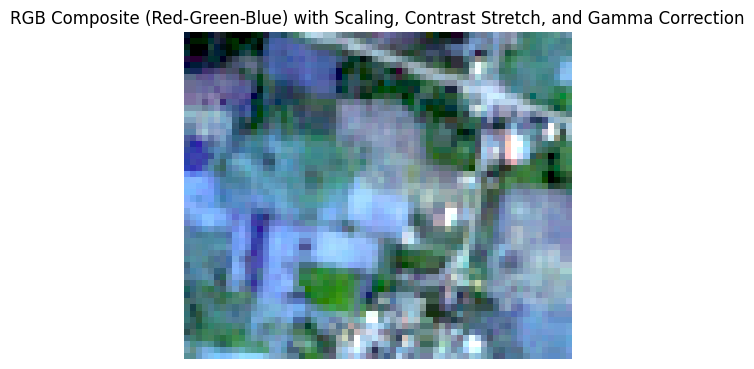

In [32]:
path = random.choice(data['tif_path'].dropna().values) 

image = visualize_rgb_image(path)

# Feature Engineering

# PySpark: 
utilized for when you have the images downloaded but dont have their vegetation indices calculated in your dataset.
**The following calculated features in PySpark are Vegetation Indices, they are useful for agriculture health predictions**

In [146]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 5.3 MB/s eta 0:00:000:00:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.4-py2.py3-none-any.whl size=317849765 sha256=c20bd11772e769531a98b15ee1e59d774ccf5199d64b35b4656abfdb2a077b7c
  Stored in directory: /root/.cache/pip/wheels/d9/1c/98/31e395a42d1735d18d42124971ecbbade844b50bb9845b6f4a
Successfully built pyspark


In [163]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit
import rasterio

spark = SparkSession.builder.appName("Crop Health Classification").getOrCreate()

def calculate_indices(tif_path):
    with rasterio.open(tif_path) as src:
        red = src.read(3).astype(float)
        green = src.read(2).astype(float)
        blue = src.read(1).astype(float)
        nir = src.read(4).astype(float)

        ndvi = (nir - red) / (nir + red)
        evi = 2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1)
        ndwi = (green - nir) / (green + nir)
        gndvi = (nir - green) / (nir + green)
        savi = ((nir - red) / (nir + red + 0.5)) * (1.5)
        msavi = (2 * nir + 1 - np.sqrt((2 * nir + 1)**2 - 8 * (nir - red))) / 2

    return {
        "path": tif_path,
        "NDVI": ndvi.mean(),
        "EVI": evi.mean(),
        "NDWI": ndwi.mean(),
        "GNDVI": gndvi.mean(),
        "SAVI": savi.mean(),
        "MSAVI": msavi.mean(),
    }

existing_df = data

# Directory containing TIFF images
image_dir = "/kaggle/input/crops-images/Telangana Images"

# Process each TIFF file and calculate indices
features_list = []
for filename in os.listdir(image_dir):
    if filename.endswith(".tif"):
        full_path = os.path.join(image_dir, filename)
        features_list.append(calculate_indices(full_path))

features_df = pd.DataFrame(features_list)

updated_df = pd.merge(existing_df, features_df, left_on="tif_path", right_on="path", how="left")
updated_df = updated_df.drop(columns=["path"])

updated_df.to_csv("updated_dataset.csv", index=False)

spark.stop()

data = updated_df

if you dont wish to use pyspark to calculate the vegetation indices of images you already have downloaded, or if you need to download the images you can uncomment the code below as it is called in parallel download of the images. 

In [155]:
"""
def calculate_ndvi(nir_band, red_band):
    """Calculate NDVI (Normalized Difference Vegetation Index)."""
    ndvi = (nir_band - red_band) / (nir_band + red_band)
    return np.nanmean(ndvi)

def calculate_evi(nir_band, red_band, blue_band):
    """Calculate EVI (Enhanced Vegetation Index)."""
    evi = 2.5 * (nir_band - red_band) / (nir_band + 6 * red_band - 7.5 * blue_band + 1)
    return np.nanmean(evi)

def calculate_ndwi(nir_band, green_band):
    """Calculate NDWI (Normalized Difference Water Index)."""
    ndwi = (green_band - nir_band) / (green_band + nir_band)
    return np.nanmean(ndwi)

def calculate_gndvi(nir_band, green_band):
    """Calculate GNDVI (Green Normalized Difference Vegetation Index)."""
    gndvi = (nir_band - green_band) / (nir_band + green_band)
    return np.nanmean(gndvi)

def calculate_savi(nir_band, red_band, L=0.5):
    """Calculate SAVI (Soil Adjusted Vegetation Index)."""
    savi = ((nir_band - red_band) / (nir_band + red_band + L)) * (1 + L)
    return np.nanmean(savi)

def calculate_msavi(nir_band, red_band):
    """Calculate MSAVI (Modified Soil Adjusted Vegetation Index)."""
    msavi = (2 * nir_band + 1 - np.sqrt((2 * nir_band + 1)**2 - 8 * (nir_band - red_band))) / 2
    return np.nanmean(msavi)
    
def process_row_for_features(index, row):
    features = {'index': index}
    tif_path = row['tif_path']
    
    if not isinstance(tif_path, str):
        print(f"Skipping entry due to missing tif_path for index {index}")
        # Add NaN for all features if path is missing
        features.update({
            'ndvi': np.nan,
            'evi': np.nan,
            'ndwi': np.nan,
            'gndvi': np.nan,
            'savi': np.nan,
            'msavi': np.nan
        })
        return features

    # Open the TIFF file and read bands for feature calculation
    with rasterio.open(tif_path) as src:
        red = src.read(3)    # B4 for Red
        green = src.read(2)  # B3 for Green
        blue = src.read(1)   # B2 for Blue
        nir = src.read(4)    # B8 for NIR

        features['ndvi'] = calculate_ndvi(nir, red)
        features['evi'] = calculate_evi(nir, red, blue)
        features['ndwi'] = calculate_ndwi(nir, green)
        features['gndvi'] = calculate_gndvi(nir, green)
        features['savi'] = calculate_savi(nir, red)
        features['msavi'] = calculate_msavi(nir, red)

    return features"""

In [ ]:
# this cell takes a lot of time to run, it downloads images and calculates indices.
# IF YOU ARE USING "data.csv" AND THE IMAGES YOU DONT HAVE TO RUN IT
new_features = Parallel(n_jobs=-1)(delayed(process_row_for_features)(index, row)
                                   for index, row in tqdm(data.iterrows(), total=len(data)))

In [ ]:
new_features_df = pd.DataFrame(new_features).set_index('index')
data = data.join(new_features_df)
data = data[data.dataset == 'train'].reset_index(drop=True)

In [ ]:
# from google.colab import files
# files.download('train_encoded.csv')
data.to_csv('data.csv', index=False)

# EDA

In [172]:
data = pd.read_csv('/kaggle/input/tele-crop-data/data.csv') # adjust 
data = data.drop([ 'ndvi', 'evi',
       'ndwi', 'gndvi', 'savi', 'msavi', 'path'],axis=1)
print(data.columns)
submission = data[data['dataset'] == 'test'] # real world data to check distributions
data  = data[data['dataset'] == 'train']
data.drop('dataset', axis = 1, inplace=True)
submission.drop(['dataset', 'category'], axis = 1, inplace=True)
print(len(data), 'records')
print(data.info())

Index(['FarmID', 'category', 'Crop', 'State', 'District', 'Sub-District',
       'SDate', 'HDate', 'CropCoveredArea', 'CHeight', 'CNext', 'CLast',
       'CTransp', 'IrriType', 'IrriSource', 'IrriCount', 'WaterCov',
       'ExpYield', 'Season', 'geometry', 'dataset', 'tif_path', 'NDVI', 'EVI',
       'NDWI', 'GNDVI', 'SAVI', 'MSAVI'],
      dtype='object')
8775 records
<class 'pandas.core.frame.DataFrame'>
Index: 8775 entries, 0 to 8774
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FarmID           8775 non-null   int64  
 1   category         8775 non-null   object 
 2   Crop             8775 non-null   object 
 3   State            8775 non-null   object 
 4   District         8775 non-null   object 
 5   Sub-District     8775 non-null   object 
 6   SDate            8775 non-null   object 
 7   HDate            8775 non-null   object 
 8   CropCoveredArea  8775 non-null   int64  
 9   CHeight        

In [173]:
for col in data.select_dtypes(include=['object']):
    print(f"\nValue counts for {col}:\n")
    print(data[col].value_counts())


Value counts for category:

category
Healthy     7214
Diseased     537
Pests        536
Stressed     488
Name: count, dtype: int64

Value counts for Crop:

Crop
Paddy          2434
Cotton         1819
Maize          1506
Chillies       1063
Bengal Gram     938
Groundnut       768
Red Gram        247
Name: count, dtype: int64

Value counts for State:

State
Telangana    8775
Name: count, dtype: int64

Value counts for District:

District
Mahabubabad     1943
Adilabad        1909
Nalgonda        1408
Medak           1285
Nirmal          1254
Mahabubnagar     655
Narayanpet       203
Nagarkurnool      47
Warangal          30
Siddipet          14
Vikarabad         11
Kamareddy          7
Wanaparthy         6
Khammam            3
Name: count, dtype: int64

Value counts for Sub-District:

Sub-District
Utnur            506
Inderavelly      345
Gudur            338
Havelighanpur    305
Ramayampet       293
                ... 
Devarkadra         3
Singareni          2
Narsapur           2
Pem

In [174]:
data.drop(['FarmID', 'State', 'geometry', 'District', 'Sub-District', 'Season'], axis=1, inplace=True)
submission.drop(['State', 'geometry', 'District', 'Sub-District', 'Season'], axis=1, inplace=True)

In [175]:
def plotNumericalDistributionOnTopOfEachOther(train: pd.DataFrame, test: pd.DataFrame, numerical_cols: list):
    
    train_copy = train[numerical_cols].copy()
    test_copy = test[numerical_cols].copy()
    train_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
    test_copy.replace([np.inf, -np.inf], np.nan, inplace=True)

    ncols = 5
    num_cols = len(numerical_cols)
    nrows = math.ceil(num_cols / ncols)  
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5 * nrows), facecolor='#EAEAF2')
    fig.tight_layout(pad=3.0)  

    if nrows == 1:
        axes = [axes]  # Wrap the axes object in a list to handle the single-row case

    for r in range(nrows):
        for c in range(ncols):
            idx = r * ncols + c  # Calculate the corresponding index for the numerical column
            if idx < num_cols:
                col = numerical_cols[idx]
                ax = axes[r][c]  # Access the subplot using two indices

                sns.histplot(x=train_copy[col], ax=ax, color='#58D68D', label='Train data', fill=True, kde=True)

                if col in test_copy.columns:  # Check if the column exists in the test data copy
                    sns.histplot(x=test_copy[col], ax=ax, color='#DE3163', label='Test data', fill=True, kde=True)

                ax.legend()
                ax.set_ylabel('')
                ax.set_xlabel(col, fontsize=12)
                ax.tick_params(labelsize=10, width=0.5)
                ax.xaxis.offsetText.set_fontsize(8)
                ax.yaxis.offsetText.set_fontsize(8)
            else:
                fig.delaxes(axes[r][c])  # Remove unused subplot

    plt.show()

In [176]:
id_col = 'FarmID'
target_col = 'category'
drop_cols = ['geometry', 'State', 'Sub-District', 'tif_path', 'ndvi', 'evi', 'ndwi', 'gndvi', 'savi', 'msavi']
date_cols = [col for col in data.columns if 'Date' in col]
categorical_cols = [col for col in data.columns if data[col].dtype == 'object' and col not in date_cols + [id_col, target_col] + drop_cols]
numerical_cols = [col for col in data.columns if data[col].dtype != 'object' and col not in [id_col] + drop_cols]
print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

Categorical columns: ['Crop', 'CNext', 'CLast', 'CTransp', 'IrriType', 'IrriSource']
Numerical columns: ['CropCoveredArea', 'CHeight', 'IrriCount', 'WaterCov', 'ExpYield', 'NDVI', 'EVI', 'NDWI', 'GNDVI', 'SAVI', 'MSAVI']


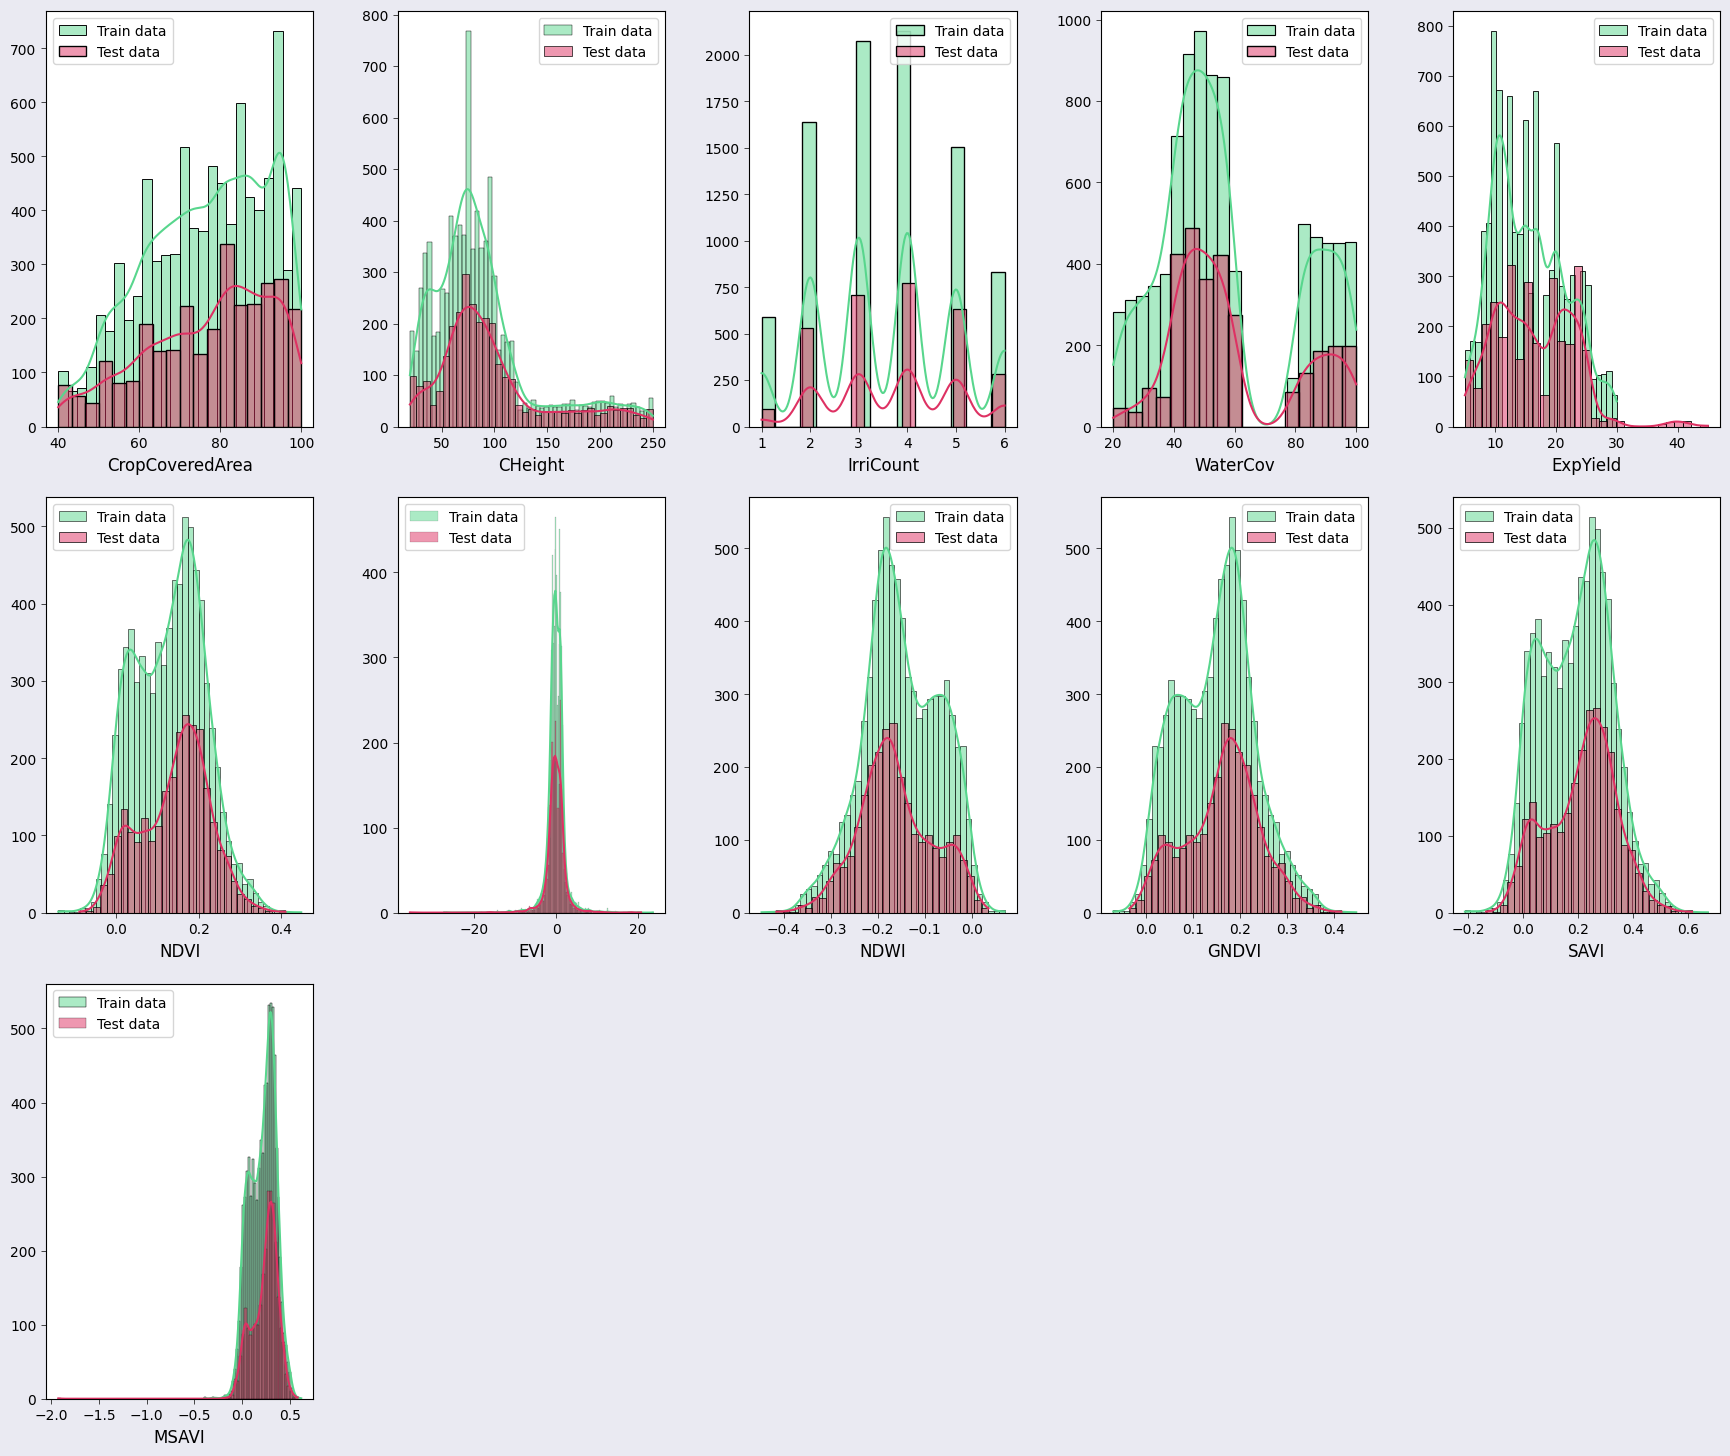

In [177]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plotNumericalDistributionOnTopOfEachOther(data, submission, numerical_cols)

* Numerical train and test data come from the same distributions
* CHeight is right skeweed  
We will apply **Log Transformation** to handle right skewness.

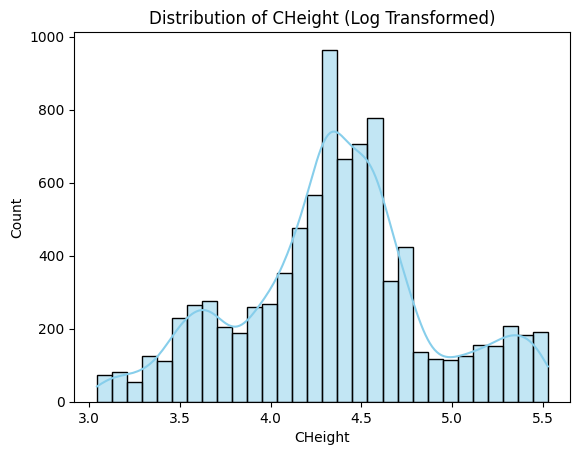

In [178]:
data['CHeight'] = np.log1p(data['CHeight'])
submission['CHeight'] = np.log1p(submission['CHeight'])
sns.histplot(data['CHeight'], kde=True, color='skyblue', bins=30)
plt.title('Distribution of CHeight (Log Transformed)')
plt.show()

# Feature Engineering

In [179]:
data['crop_last_current__next'] = data['CLast'] + "_" + data['Crop'] + '_' + data['CNext']
submission['crop_last_current__next'] = submission['CLast'] + "_" + submission['Crop'] + '_'+ submission['CNext']
data.drop(['CNext', 'Crop', 'CLast'], axis=1, inplace = True)
submission.drop(['CNext', 'Crop', 'CLast'], axis=1, inplace = True)

In [180]:
data['SDate'] = pd.to_datetime(data['SDate'],dayfirst=True)
data['HDate'] = pd.to_datetime(data['HDate'], dayfirst=True)
data['Duration'] = (data['HDate'] - data['SDate']).dt.days

submission['SDate'] = pd.to_datetime(submission['SDate'],dayfirst=True)
submission['HDate'] = pd.to_datetime(submission['HDate'], dayfirst=True)
submission['Duration'] = (submission['HDate'] - submission['SDate']).dt.days

# Dates Validity
886 Records have invalid Sow and Harvest Dates.

In [181]:
print(len(data[data['Duration']<0]))
print(len(submission[submission['Duration']<0]))

886
297


In [182]:
# Keep only rows where 'Duration' is greater than or equal to 0
data = data[data['Duration'] >= 0]
submission = submission[submission['Duration'] >= 0]
print('Records after dropping records with invalid dates:', len(data))
print('Records after dropping records with invalid dates:', len(submission))
print(len(data[data['Duration']<0]))
print(len(submission[submission['Duration']<0]))

Records after dropping records with invalid dates: 7889
Records after dropping records with invalid dates: 2719
0
0


In [183]:
data.drop(['SDate','HDate'], axis=1, inplace=True)
submission.drop(['SDate','HDate'], axis=1, inplace=True)

# Preparations for the CNN MODEL

In [184]:
data['tif_path'] = data['tif_path'].apply(
    lambda x: x.replace('/kaggle/input/telangana-images/Telangana Images', '/kaggle/input/crops-images/Telangana Images') 
    if isinstance(x, str) else x
)

In [185]:
missing_data_paths = data[data['tif_path'].isnull()]
missing_submission_paths = submission[submission['tif_path'].isnull()]
print(f"Missing paths in data set: {len(missing_data_paths)}")
print(f"Missing paths in submission set: {len(missing_submission_paths)}")

# Drop rows with missing paths
data = data[data['tif_path'].notnull()]
submission = submission[submission['tif_path'].notnull()]

Missing paths in data set: 9
Missing paths in submission set: 4


In [186]:
print(len(data))
print(len(submission))

X = data.drop('category', axis=1)
y = data['category']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(len(X_train),len(X_test))

7880
2715
6304 1576


In [187]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

In [188]:
# create two lists containing image_names for training and testing
image_base_path = '/kaggle/input/crops-images/Telangana Images/'
train_images,test_images,submission_images = [],[],[]

for path in X_train['tif_path']:
    image_name = path.replace(image_base_path,'')
    train_images.append(image_name)
    
for path in X_test['tif_path']:
    image_name = path.replace(image_base_path,'')
    test_images.append(image_name)

for path in submission['tif_path']:
    image_name = path.replace(image_base_path,'')
    submission_images.append(image_name)

train_images_labels = y_train.tolist()
test_images_labels = y_test.tolist()

print(train_images[:5])
print(test_images[:5])
print(submission_images[:5])
print(train_images_labels[:5])
print(test_images_labels[:5])

['20240212T050939_20240212T051719_T43QHB_RGB_2023-12-12_2024-02-17.tif', '20240207T051001_20240207T052026_T43QGU_RGB_2023-11-19_2024-02-10.tif', '20240803T051649_20240803T052816_T43QHA_RGB_2023-06-11_2024-08-05.tif', '20240415T051649_20240415T053023_T43QGA_RGB_2023-03-10_2024-04-19.tif', '20240422T050649_20240422T051633_T43QHB_RGB_2023-03-11_2024-04-23.tif']
['20240123T051119_20240123T052221_T43QGU_RGB_2023-11-14_2024-01-24.tif', '20240412T050649_20240412T051727_T43QHV_RGB_2023-12-25_2024-04-13.tif', '20231229T051221_20231229T052219_T43QHB_RGB_2023-08-10_2024-01-03.tif', '20240430T051651_20240430T053056_T43QHA_RGB_2023-10-10_2024-05-02.tif', '20240522T050649_20240522T051545_T43QHV_RGB_2023-11-12_2024-05-27.tif']
['20240512T050649_20240512T051901_T44QKE_RGB_2023-11-12_2024-05-14.tif', '20240527T050651_20240527T051452_T44QKE_RGB_2023-12-20_2024-05-28.tif', '20240517T050651_20240517T051655_T43QHA_RGB_2023-11-29_2024-05-18.tif', '20240422T050649_20240422T051633_T43QHA_RGB_2023-01-11_2024-0

In [189]:
def preprocess_images(images_dir,images):
    preprocessed_images = []
    for image in images:
        img_path = os.path.join(images_dir, image)
        img = tiff.imread(img_path)
        if img.ndim == 3 and img.shape[-1] > 3:
                img = img[:, :, :3]  #select the first 3 channels
        img = (img / np.max(img) * 255).astype(np.uint8) #normalize and convert to uint8
        img_resized = Image.fromarray(img).resize((64, 64)) #resize image
        img_array = np.array(img_resized) #image to array
        img_array = img_array / 255.0  #normalize pixel values
        preprocessed_images.append(img_array)
    return np.array(preprocessed_images)

In [190]:
images_dir = '/kaggle/input/crops-images/Telangana Images'
X_train_preprocessed_images = preprocess_images(images_dir,train_images)
X_test_preprocessed_images = preprocess_images(images_dir,test_images)

In [191]:
to_split = int(len(X_train_preprocessed_images) * 0.8)
X_train_images = X_train_preprocessed_images[:to_split]
X_val_images = X_train_preprocessed_images[to_split:]
X_test_images = X_test_preprocessed_images

y_train_images = train_images_labels[:to_split]
y_train_images = np.array(y_train_images)
y_val_images = train_images_labels[to_split:]
y_val_images = np.array(y_val_images)
y_test_images = test_images_labels
y_test_images = np.array(y_test_images)

print(len(X_train_images),len(X_val_images),len(X_test_images))
print(len(y_train_images),len(y_val_images),len(y_test_images))

5043 1261 1576
5043 1261 1576


# CNN Model: EfficientNetB0

In [192]:
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(64, 64, 3)
)

model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(4, activation='softmax', kernel_regularizer=l2(0.001))
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [193]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_images),
    y=y_train_images
)

history = model.fit(
    X_train_images,
    y_train_images,
    validation_data=(X_val_images, y_val_images),
    epochs=60,
    batch_size=32,
    class_weight={i: weight for i, weight in enumerate(class_weights)},
    verbose=1
)

Epoch 1/60
158/158 ━━━━━━━━━━━━━━━━━━━━ 93s 248ms/step - accuracy: 0.2685 - loss: 1.7609 - val_accuracy: 0.0761 - val_loss: 1.4441
Epoch 2/60
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.2839 - loss: 1.6234 - val_accuracy: 0.0619 - val_loss: 1.4187
Epoch 3/60
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.3107 - loss: 1.4193 - val_accuracy: 0.1911 - val_loss: 1.4056
Epoch 4/60
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.3092 - loss: 1.3843 - val_accuracy: 0.2672 - val_loss: 1.5488
Epoch 5/60
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.3229 - loss: 1.2237 - val_accuracy: 0.2554 - val_loss: 1.5357
Epoch 6/60
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.3513 - loss: 1.1573 - val_accuracy: 0.3140 - val_loss: 1.4273
Epoch 7/60
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.3812 - loss: 1.0769 - val_accuracy: 0.3125 - val_loss: 1.3962
Epoch 8/60
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4049 - loss: 1.0031 - val_ac

In [194]:
test_loss, test_accuracy = model.evaluate(X_test_images, y_test_images, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.6439 - loss: 1.6334
Test Loss: 1.617112398147583
Test Accuracy: 0.6453045606613159


In [195]:
cnn_predictions = model.predict(X_test_images)
y_pred_cnn = np.argmax(cnn_predictions, axis=1)

f1_cnn = f1_score(y_test_images, y_pred, average='weighted')
print(f"CNN F1 Score: {f1_cnn}")
accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
print(f"CNN Accuracy: {accuracy_cnn}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step
CNN F1 Score: 0.662948927818784
CNN Accuracy: 0.6453045685279187


In [196]:
# Generate confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_images, y_pred_cnn))

Confusion Matrix:
[[   8   75    6    6]
 [ 159 1003   73   65]
 [  10   75    6    6]
 [   9   67    8    0]]


# One-hot Encoding 

In [197]:
data = data.drop('tif_path',axis = 1)

In [198]:
data.columns

Index(['category', 'CropCoveredArea', 'CHeight', 'CTransp', 'IrriType',
       'IrriSource', 'IrriCount', 'WaterCov', 'ExpYield', 'NDVI', 'EVI',
       'NDWI', 'GNDVI', 'SAVI', 'MSAVI', 'crop_last_current__next',
       'Duration'],
      dtype='object')

In [199]:
numerical_features = data.select_dtypes(include=['int64', 'float64'])
categorical_features = data.select_dtypes(include=['object'])
categorical_to_onehot = categorical_features.drop(columns=['category'],axis = 1)
categorical_to_label = categorical_features['category']

In [200]:
data = pd.get_dummies(data, columns=categorical_to_onehot.columns, drop_first=False)

# Label Encoding the "category" feature

In [201]:
label_encoder = LabelEncoder()
data['category'] = label_encoder.fit_transform(categorical_to_label)

# Handling Problematic Values

In [202]:
print("Missing Values in 'data':")
print(data.isnull().sum()[data.isnull().sum() > 0].to_frame('Missing Values').sort_values('Missing Values', ascending=False))

Missing Values in 'data':
       Missing Values
NDVI              138
NDWI              138
GNDVI             138
EVI                31


In [204]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
# columns_to_impute = ['ndvi', 'evi', 'ndwi', 'gndvi', 'savi', 'msavi']
columns_to_impute = ['NDVI', 'EVI',
       'NDWI', 'GNDVI', 'SAVI', 'MSAVI']
for col in columns_to_impute:
    data[col] = data[col].fillna(data[col].median()) 

In [205]:
missing_percent = (submission.isnull().sum() / len(submission)) * 100
print(missing_percent[missing_percent > 0])

NDVI     0.883978
EVI      0.036832
NDWI     0.883978
GNDVI    0.883978
dtype: float64


# Scaling

In [206]:
X = data.drop('category', axis=1)
y = data['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [207]:
to_split = int(len(X_train) * 0.8)
X_val = X_train[to_split:]
X_train = X_train[:to_split]

y_val = y_train[to_split:]
y_train = y_train[:to_split]

print(len(X_train),len(X_val),len(X_test))
print(len(y_train),len(y_val),len(y_test))

5043 1261 1576
5043 1261 1576


In [208]:
scaler = StandardScaler()
X_train[numerical_features.columns] = scaler.fit_transform(X_train[numerical_features.columns])
X_test[numerical_features.columns] = scaler.transform(X_test[numerical_features.columns])

# Feature Importance Using RandomForest

In [209]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

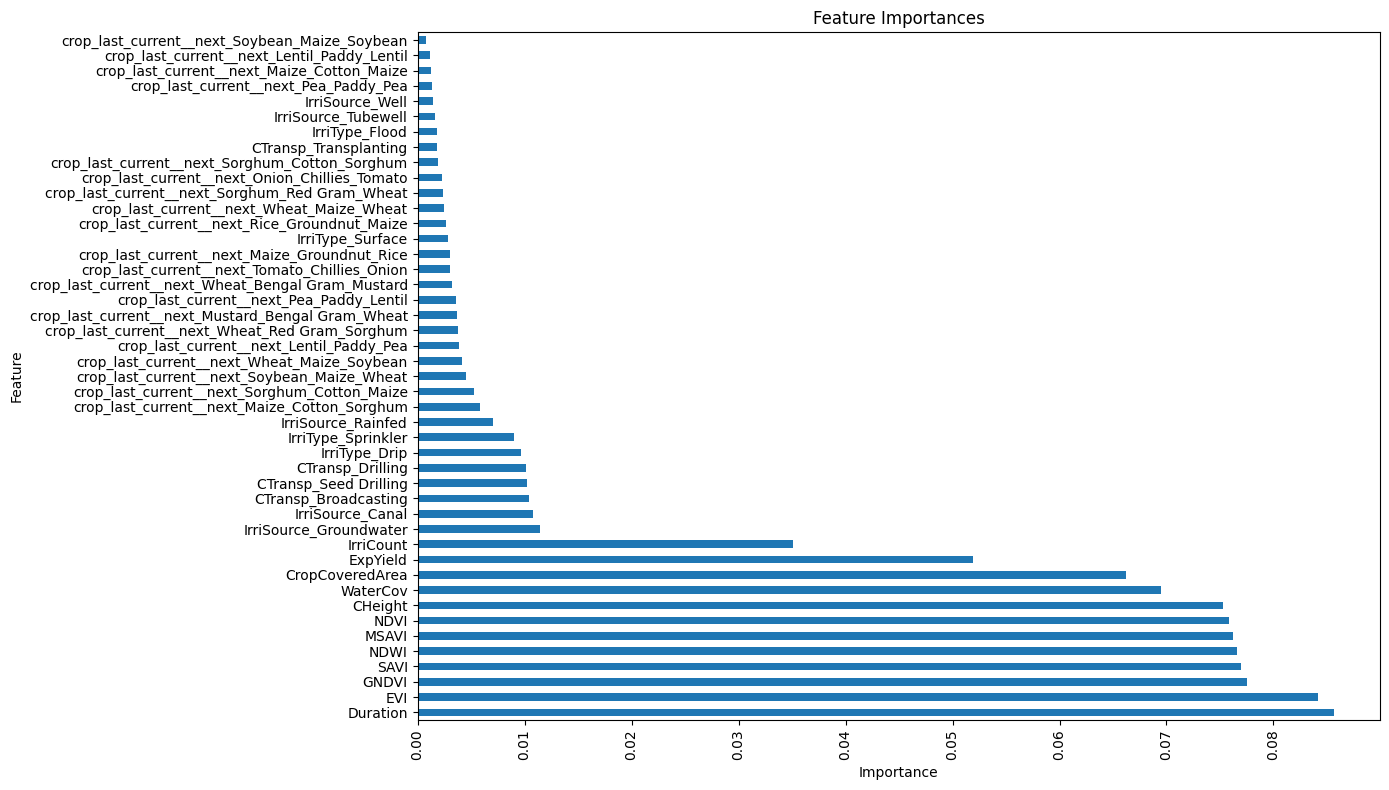

In [210]:
plt.figure(figsize=(14, 8))
feature_importances.plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.xticks(rotation=90) 
plt.tight_layout() 
plt.show()

# MLP


## 7-layer MLP with Batch Normalization

In [211]:
def create_mlp_with_bn(input_dim, output_dim):
    model = Sequential([
        Dense(256, input_dim=input_dim),  
        BatchNormalization(),
        tf.keras.layers.ReLU(),
        Dropout(0.3),

        Dense(128),  # Second hidden layer
        BatchNormalization(),
        tf.keras.layers.ReLU(),
        
        Dense(128),  
        BatchNormalization(),
        tf.keras.layers.ReLU(),
        
        Dense(64),  # Fourth hidden layer
        BatchNormalization(),
        tf.keras.layers.ReLU(),

        Dense(64),  
        BatchNormalization(),
        tf.keras.layers.ReLU(),

        Dense(32),  # Sixth hidden layer
        BatchNormalization(),
        tf.keras.layers.ReLU(),
        
        Dense(output_dim, activation='softmax')  
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

input_dim = X_train.shape[1]  # Number of features 
output_dim = y_train_encoded.shape[1]  # Number of unique classes 

mlp_model_bn = create_mlp_with_bn(input_dim, output_dim)
history = mlp_model_bn.fit(X_train, y_train_encoded, epochs=60, 
                           batch_size=32, validation_split=0.2,
                           verbose=1)

# y_pred_probs_bn = mlp_model_bn.predict(X_test)
mlp_predictions = mlp_model_bn.predict(X_test)
y_pred_bn = tf.argmax(mlp_predictions, axis=1).numpy()
f1_bn = f1_score(y_test, y_pred_bn, average='weighted')
print(f"MLP F1 Score: {f1_bn}")
accuracy_bn = accuracy_score(y_test, y_pred_bn)
print(f"MLP Accuracy: {accuracy_bn}")

Epoch 1/60
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.3056 - loss: 1.5951 - val_accuracy: 0.8305 - val_loss: 0.8595
Epoch 2/60
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8131 - loss: 0.7198 - val_accuracy: 0.8305 - val_loss: 0.6714
Epoch 3/60
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8069 - loss: 0.7023 - val_accuracy: 0.8305 - val_loss: 0.6561
Epoch 4/60
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8093 - loss: 0.6899 - val_accuracy: 0.8305 - val_loss: 0.6635
Epoch 5/60
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8130 - loss: 0.6712 - val_accuracy: 0.8305 - val_loss: 0.6609
Epoch 6/60
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8220 - loss: 0.6455 - val_accuracy: 0.8305 - val_loss: 0.6662
Epoch 7/60
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8128 - loss: 0.6608 - val_accuracy: 0.8305 - val_loss: 0.6564
Epoch 8/60
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8203 - loss: 0.6468 - val_accuracy: 

# Late Fusion of Models

In [212]:
# fused_predictions = (cnn_predictions + mlp_predictions) / 2
cnn_weight = 0.4
mlp_weight = 0.6
fused_predictions = (cnn_weight * cnn_predictions) + (mlp_weight * mlp_predictions)
final_predictions = np.argmax(fused_predictions, axis=1)

f1_fused = f1_score(y_test, final_predictions, average='weighted')
print(f"F1 Score (Late Fusion): {f1_fused}")
accuracy_fused = accuracy_score(y_test, final_predictions)
print(f"Accuracy (Late Fusion): {accuracy_fused}")

F1 Score (Late Fusion): 0.7470527939372321
Accuracy (Late Fusion): 0.8083756345177665
